In [1]:
import sys
sys.path.append("../code")

In [2]:
from manuscript import coefs

In [3]:
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [4]:
import numpy as np
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [6]:
from BodyPartsPy.optimize import find_organ_coefficients, modify_net, get_rel_flows
from BodyPartsPy.flows import solve_flows
import networkx as nx

### Solve flow network
Here we load some pre-computed coefficients to speed-up calculations. 

In [7]:
network_pickled = "../output/data/flow_networks/main_network.p"
boundary_conditions_csv = "../output/data/boundary_conditions/main_boundary_conditions.csv"
connections = pd.read_pickle("../output/data/flow_networks/main_connections.p")
organs_dict = pd.read_pickle("../output/data/optimization/organs_dict.p")
organs_target = pd.read_pickle("../output/data/optimization/organs_targets.p")

net = pd.read_pickle(network_pickled)
boundary_conditions = dict(pd.read_csv(boundary_conditions_csv, header=None).values)
organs_list = list(organs_dict.keys())
nnet = modify_net(coefs, organs_list, organs_dict, net)

Alternatively, to re-run all steps and obtain the solved network in one go, run
```bash
make output/data/solved_flow_networks/solved_main_network.p
```
Solve the flow problem:

In [8]:
dinet = solve_flows(
    net=nnet,
    boundary_conditions=boundary_conditions,
    root=list(boundary_conditions.keys())
)

Save solved network for later use

In [9]:
pd.to_pickle(dinet, "../output/data/solved_flow_networks/solved_main_network.p")

### Compare to blood flow fraction data

In [10]:
organs_rel_flows = get_rel_flows(organs_dict, dinet, boundary_conditions)

In [11]:
comparison = pd.DataFrame({
    "literature": organs_target,
    "model": organs_rel_flows
})
comparison["abs_err"] = comparison.model - comparison.literature
comparison.index.name="organ"
comparison = comparison.reset_index()
comparison_long = comparison.drop(7).drop("abs_err", axis=1).melt(id_vars=["organ"], var_name="blood_flow_fraction")
comparison["_organ"] = comparison.organ.apply(lambda x: x.replace("left_", "").replace("right_", ""))
_comparison = comparison.groupby("_organ").mean().reset_index()
comparison_long = _comparison.melt(id_vars=["_organ"], value_vars=["literature", "model"])
_comparison.sort_values(by="literature", ascending=True, inplace=True)

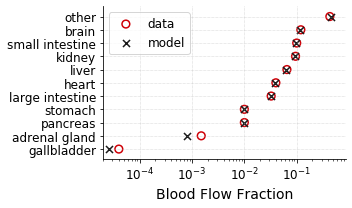

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)
ylabels = [x.replace("_", " ") for x in _comparison._organ.values]
yticks =  range(len(ylabels))

x_data = _comparison.literature.values
x_model = _comparison.model.values

ax.scatter(
    x_data, yticks,
    facecolors='none',
    edgecolors='#cf0007',
    marker="o",
    linewidth=1.5,
    s=60,
    label="data"
)
ax.scatter(
    x_model, yticks,
    #facecolors='none',
    #edgecolors='0.2',
    color="0.1",
    marker="x",
    s=50,
    label="model"
)
ax.legend(loc=2)
ax.grid(linewidth=0.5, linestyle="dotted")
ax.set_yticks(yticks);
ax.set_yticklabels(ylabels);
ax.set_xscale("log")
ax.set_xlabel("Blood Flow Fraction")
ax.set_xlim(0.5*min(x_data), 2*max(x_data));
fig.savefig("../figures/whole-body-flow-plots/blood-flow-fraction.png", dpi=300)